In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
import os
sys.path.append(os.getcwd() + "/tabnet-develop/")

from sklearn.cluster import DBSCAN

## 0. Configuration Parameters
Customizing constants for the run(s).

In [19]:
# config
np.random.seed(2123)

## 1. Datasets

### 1.0. Create or load dataset
As of now, only a toy dataset is used (3 features with 3 clusters centered around different points).

In [20]:
from sklearn.datasets import make_blobs

features, clusters = make_blobs(n_samples=[50, 100, 50],
                                centers=[[1, 5, 1], [7, 12, 9], [10, 2, 5]],
                                n_features=3,
                                cluster_std=1.5, )

### 1.1. plot data

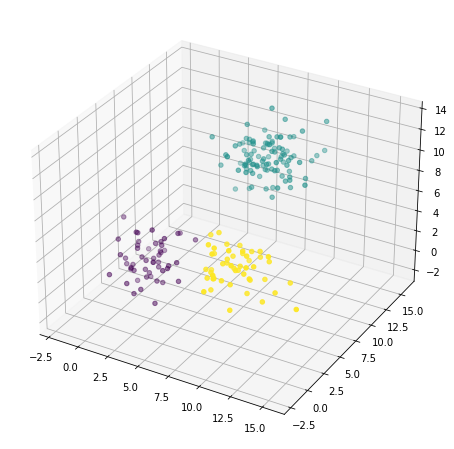

In [248]:
# plot dataset
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=clusters)
plt.show()

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [21]:
# name feature and cluster (ground truth) columns
features = pd.DataFrame(features, columns=[f"F{x + 1}" for x in range(features.shape[1])])
clusters = pd.DataFrame(clusters, columns=["C"])

# create missing values in feature column(s)
mv_percent = [0, 15, 10]  # percentages of missing values created in the feature columns
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), mv_percent)}
features_mv = features.copy()

for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv / 100)

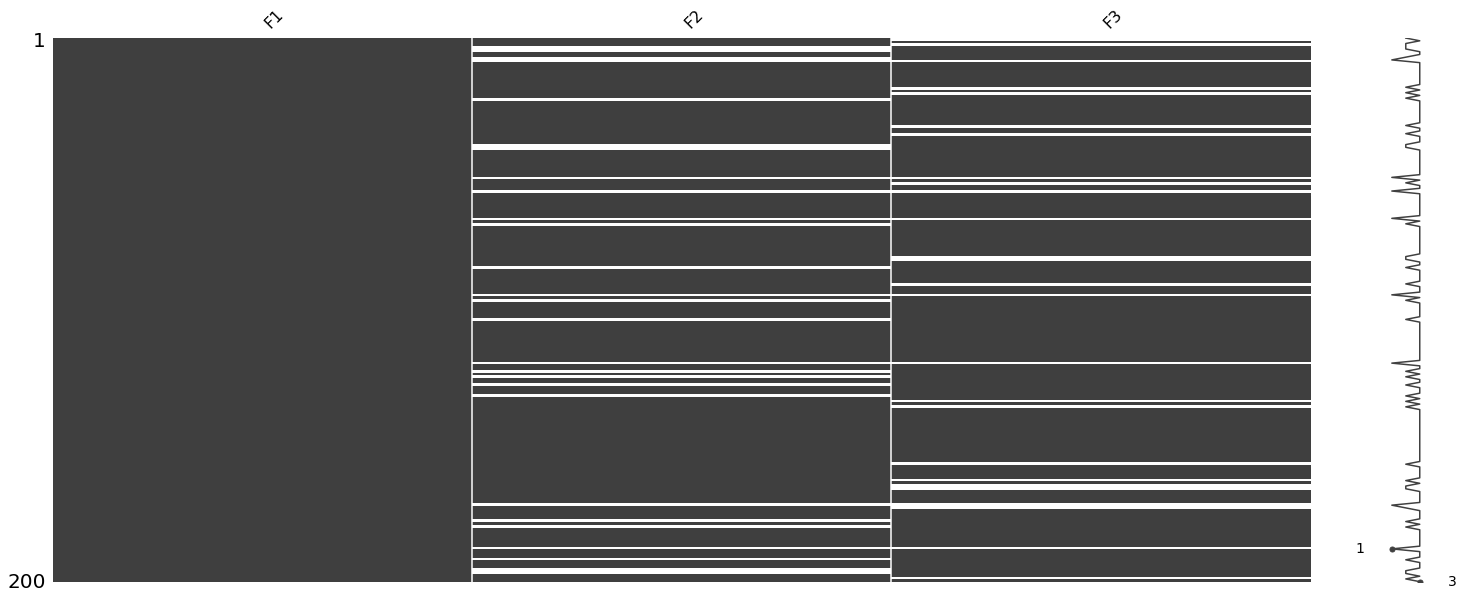

In [206]:
import missingno as msno

# plot missing values
msno.matrix(features_mv)
plt.show()

### 1.3. Initial Clustering (without missing values)
Use the cluster algorithm on dataset without missing values.\
Get cluster means for loss function input.

In [22]:
dbscan = DBSCAN(eps=3, min_samples=5).fit(features)
clusters = dbscan.labels_

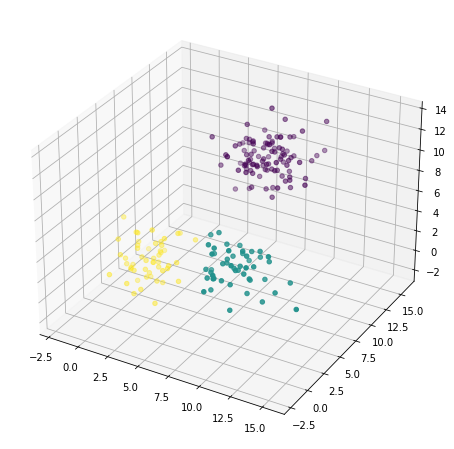

In [238]:
# plot clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters)
plt.show()

In [23]:
# get cluster means
complete_data = features
complete_data["C"] = clusters
cluster_means = complete_data.groupby("C").agg("mean")


## 2. Filling Strategies
Fill missing values (here with TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; Problem: Still one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

**Approach 3:**\
tbd


In [24]:
# define custom loss function: extend L2-loss by cluster-mean-loss and boundary-loss
# Problem: standard Metric implementation of TabNet does not allow for other parameters (like cluster_means)
#          This will probably require adaptions in pytorch_tabnet/abstract_model.py to use aditional parameters
#          510         metrics_logs = self._metric_container_dict[name](y_true, scores)
#          calling pytorch_tabnet/metrics.py
#          142         res = metric(y_true, y_pred)

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error

class cluster_loss(Metric):

    def __init__(self):
        self._name = "cluster_loss"
        self._maximize = False

    def __call__(self, y_true, y_score):
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        cluster_mean_loss = 0
        boundary_loss = 0
        cluster_loss = rmse + cluster_mean_loss + boundary_loss
        return cluster_loss

In [25]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_filled = features_mv.copy()

for feature in features_mv.columns[features_mv.isnull().any()]:
    print(feature)
    
    # mask other columns' missing values as -1
    features_mv_masked = features_mv.copy()
    other_features = [col for col in features_mv.columns if col != feature]
    features_mv_masked[other_features] = features_mv_masked[other_features].fillna(-1)

    # separate complete rows as train data
    # separate column with missing values as target
    missing_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
    train_data = features_mv_masked[features_mv_masked[feature].notna()]
    train_features = train_data.drop(columns=feature).to_numpy()
    train_target = train_data[feature].to_numpy().reshape(-1,1)
    
    x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.75)
    
    # create & train model
    model = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                        optimizer_params=dict(lr=2e-2),
                        scheduler_params={"step_size": 50, "gamma": 0.9},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        mask_type='entmax')

    model.fit(
        x_train, y_train,
        eval_set=[(x_val, y_val)],
        eval_metric=['rmse'],
        max_epochs=100, patience=20,
    )
    
    # fill missing values with model predictions
    features_filled.loc[features_filled[feature].isna(),feature] = [x[0] for x in model.predict(missing_data)]

F2
Test
epoch 0  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 1  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 2  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 3  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 4  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 5  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 6  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 7  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 8  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 9  | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 10 | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 11 | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 12 | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 13 | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 14 | loss: 0.0     | val_0_rmse: 54.38966|  0:00:00s
Test
epoch 15 | loss: 0.0     | val_0

/Users/julianhoffmeister/Library/Mobile Documents/com~apple~CloudDocs/Uni/Bachelorthesis/05_code/feature_learning/tabnet-develop/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/Users/julianhoffmeister/Library/Mobile Documents/com~apple~CloudDocs/Uni/Bachelorthesis/05_code/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/Users/julianhoffmeister/Library/Mobile Documents/com~apple~CloudDocs/Uni/Bachelorthesis/05_code/feature_learning/tab

Test
epoch 0  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 1  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 2  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 3  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 4  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 5  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 6  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 7  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 8  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 9  | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 10 | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 11 | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 12 | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 13 | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 14 | loss: 0.0     | val_0_rmse: 53.28518|  0:00:00s
Test
epoch 15 | loss: 0.0     | val_0_rm

/Users/julianhoffmeister/Library/Mobile Documents/com~apple~CloudDocs/Uni/Bachelorthesis/05_code/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/Users/julianhoffmeister/Library/Mobile Documents/com~apple~CloudDocs/Uni/Bachelorthesis/05_code/feature_learning/tabnet-develop/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 3. Complete Dataset
Complete dataset and deviation of original dataset

In [221]:
# complete dataset
features_filled

,F1,F2,F3
0,8.265864,13.031708,7.268530
1,9.067304,11.340618,9.692263
2,7.266311,3.162840,6.713374
3,9.417707,13.754110,8.236927
4,8.313350,13.924866,9.585304
...,...,...,...
195,8.166044,14.182239,7.314758
196,6.781406,11.409457,8.367899
197,9.383646,-0.471206,7.549884
198,10.121086,-1.678311,6.800494


In [222]:
# prediction errors
(features_filled - features).abs().sum()

F1      0.000000
F2    163.440477
F3     71.229838
dtype: float64

## 4. Clustering

In [234]:
# apply clustering
dbscan = DBSCAN(eps=3, min_samples=5).fit(features_filled)
clusters_filled = dbscan.labels_

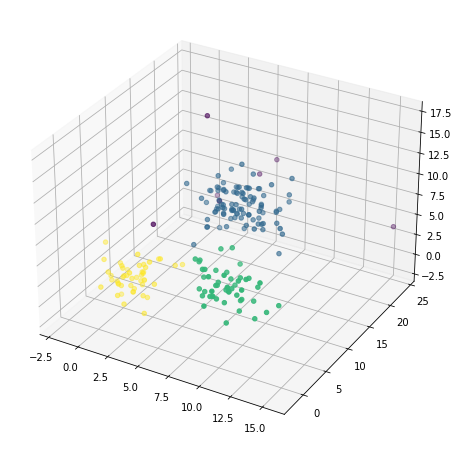

In [235]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_filled.iloc[:, 0], features_filled.iloc[:, 1], features_filled.iloc[:, 2], c=clusters_filled)
plt.show()

## 5. Cluster Performance
to be implemented